In [187]:
import numpy as np
import scipy
import matplotlib.pyplot as plt



SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220

## Record Audio

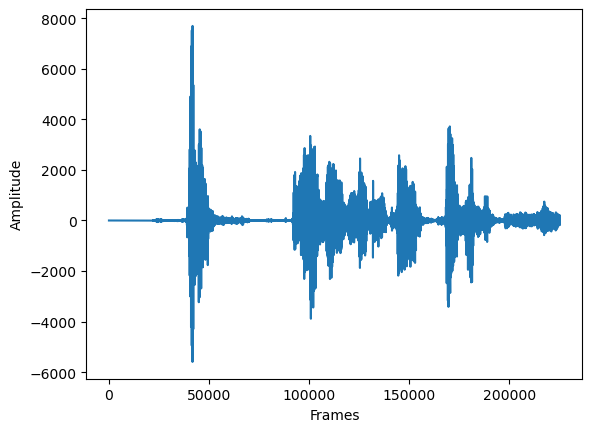

In [188]:
import pyaudio

def recordAudio():
    p = pyaudio.PyAudio()
    FORMAT = pyaudio.paInt16

    stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ, input=True, frames_per_buffer=FRAMESIZE)
    data = stream.read(NOFFRAMES*FRAMESIZE)
    decoded = np.frombuffer(data, "int16")
    stream.stop_stream()
    stream.close()
    return decoded

data = recordAudio()
plt.plot(data)
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()



# Input normalisieren

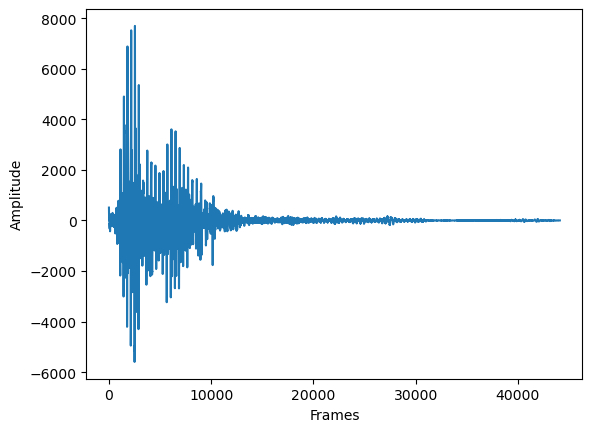

In [189]:
def normInput(decoded):
    for i, v in enumerate(decoded):
        if v > 500:
            decoded = decoded[i:]
            break
    if len(decoded) > SAMPLEFREQ:
        decoded = decoded[:SAMPLEFREQ]
    while len(decoded) < SAMPLEFREQ:
        np.append(decoded, 0)
    return decoded

plt.plot(normInput(data))
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()

In [ ]:
typ = "Referenzen"
befehl = "hoch"
name = ""
for i in range(5):
    data = normInput(recordAudio())
    if len(name) == 0:
        np.save(f"Messdaten/{typ}/{befehl}/{befehl}{i}", data)
    else:
        np.save(f"Messdaten/{typ}/{name}/{befehl}/{befehl}{i}", data)

# Import npy file

In [190]:
data = np.load("Messdaten/hoch/hoch0.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'Messdaten/hoch/hoch0.npy'

# Amplitudenspektrum

In [ ]:
fourier_transform = np.fft.fft(data)
amplituden = np.abs(fourier_transform)

plt.plot(amplituden[:1000])
plt.xlabel('Frames')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectrum')

# Windowing

In [ ]:
def windowing(win_data):
    windowSize = 512
    window = scipy.signal.windows.gaussian(windowSize, std=windowSize/4)
    windows_fft = []

    for i in range(0, SAMPLEFREQ, int(windowSize/2)):
        localData = data[i:i+windowSize]
        if len(localData) != 512:
            continue
        local_fft = np.fft.fft(localData*window)
        windows_fft.append(local_fft)
    mean_fft = np.array(windows_fft).mean(axis=0)
    amplituden = np.abs(mean_fft)
    return amplituden

In [ ]:
plt.plot(windowing(data)[:20])
plt.title("Amplitude Spectrum")
plt.xlabel("Amplitude")
plt.ylabel("Frequenz (hz)")
plt.show()

# Daten einlesen

In [ ]:

befehle = ["hoch", "runter", "links", "rechts"]
befehle = ["hoch", "runter"]

ref_dict = {}
for idx, befehl in enumerate(befehle):
    ref_dict[befehl] = []
    for i in range(2):
        data = np.load(f"Messdaten/{befehl}/{befehl}{i}.npy")
        ref_dict[befehl].append(windowing(data))
    ref_dict[befehl] = np.array(ref_dict[befehl]).mean(axis=0)
    plt.subplot(2,2, idx+1)
    plt.plot(ref_dict[befehl][:20])
    plt.title(befehl)

plt.show()


# Testdatensätze

In [ ]:
tests_dict = {}
namen = ["jonas", "hannes"]

for name in namen:
    for idx, befehl in enumerate(befehle):
        tests_dict[name][befehl] = []
        for i in range(5):
            data = np.load(f"Messdaten/{befehl}/{befehl}{i}.npy")
            tests_dict[name][befehl].append(windowing(data))
        tests_dict[name][befehl] = np.array(tests_dict[name][befehl]).mean(axis=0)


# Korrelation

In [ ]:
def get_korr(input, ref):
    kovarianz = np.corrcoef(input-np.mean(input),ref-np.mean(ref))
    return kovarianz/(np.std(input)*np.std(ref))


# Vergleich

In [ ]:
korr_dict = {}
for befehl in befehle:
    ref = ref_dict[befehl]
    for name in namen:
        korr_dict[befehl][name] = get_korr(tests_dict[name][befehl], ref)


for befehl, names in korr_dict.items():
    for name, korr in names:
        print(f"{name} mit Befehlt {befehl} korreliert mit {korr}")

